<a href="https://colab.research.google.com/github/eshita1802/Continuous-Authentication/blob/main/Basic_kNN%2C_KDA%2C_Logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix
import joblib


In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

# Configuration
WINDOW_SIZE = 100  # 2 seconds at 50Hz
STEP_SIZE = 50
SENSORS = ['Ax', 'Ay', 'Az',
          'Gx', 'Gy', 'Gz',
          'Lx', 'Ly', 'Lz',
          'Mx', 'My', 'Mz']
ACTIVITIES = ['Standing', 'Sitting', 'Running', 'Biking', 'Walking',
             'Walking Upstairs', 'Walking Downstairs']
POSITIONS = ['left_pocket', 'right_pocket', 'upper_arm', 'belt', 'wrist']



In [ ]:
def load_and_process_data(folder_path):
    """Load all Excel files and process into features"""
    all_files = glob(os.path.join(folder_path, "*.xlsx"))
    features_list = []
    labels_list = []

    for file_path in all_files:
        filename = os.path.basename(file_path).replace('.xlsx', '')
        parts = filename.split('_')

        # Identify activity and position
        activity, position = None, None
        for i in range(len(parts), 0, -1):
            test_position = '_'.join(parts[i:])
            test_activity = '_'.join(parts[:i])

            if test_activity in ACTIVITIES and test_position in POSITIONS:
                activity = test_activity
                position = test_position
                break

        if not activity or not position:
            continue

        # Read and process data
        df = pd.read_excel(file_path)
        df = df[['participant_id'] + SENSORS].apply(pd.to_numeric, errors='coerce')
        df.dropna(inplace=True)

        # Create windows and features
        for user in df['participant_id'].unique():
            user_df = df[df['participant_id'] == user]
            for i in range(0, len(user_df)-WINDOW_SIZE, STEP_SIZE):
                window = user_df.iloc[i:i+WINDOW_SIZE]
                features = extract_features(window)
                features_list.append(features)
                labels_list.append(user)

    return np.array(features_list), np.array(labels_list)



In [ ]:
def extract_features(window):
    """Feature extraction with sensor fusion"""
    features = []

    # Time-domain features
    for sensor in SENSORS:
        x = window[sensor].values
        features += [
            np.mean(x), np.std(x), np.min(x), np.max(x),
            np.percentile(x, 25), np.percentile(x, 75)
        ]

    # Sensor fusion features
    accel = window[['Ax', 'Ay', 'Az']].values
    gyro = window[['Gx', 'Gy', 'Gz']].values

    features += [
        np.mean(np.linalg.norm(accel, axis=1)),
        np.std(np.linalg.norm(accel, axis=1)),
        np.mean(np.linalg.norm(gyro, axis=1)),
        np.std(np.linalg.norm(gyro, axis=1)),
        np.corrcoef(accel[:,0], gyro[:,0])[0,1],
        np.corrcoef(accel[:,1], gyro[:,1])[0,1],
        np.corrcoef(accel[:,2], gyro[:,2])[0,1]
    ]

    return np.array(features)


Loading data...
Dataset shape: (402560, 79) | Classes: 10

Selecting top features...


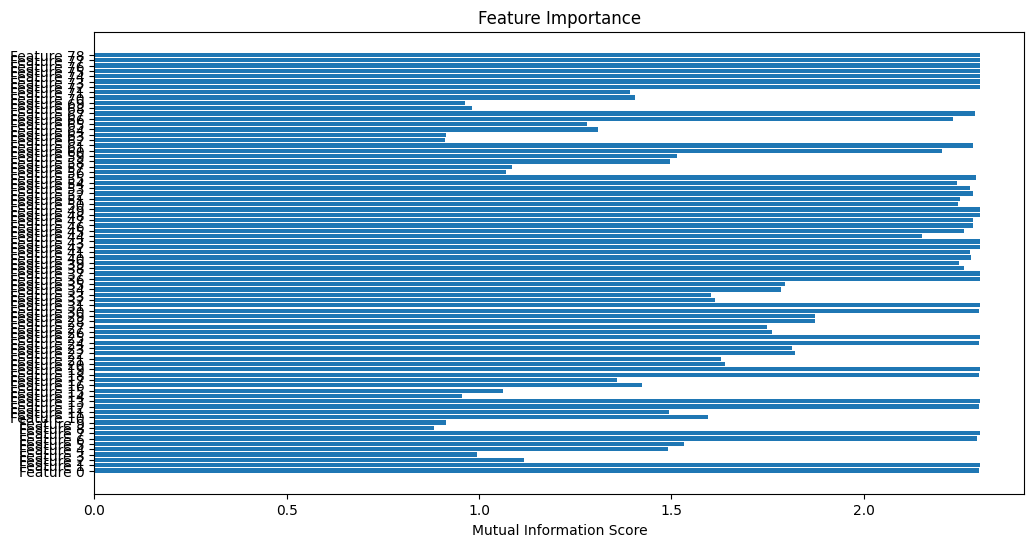


Evaluating models:
LDA: 0.26 ± 0.00
kNN: 1.00 ± 0.00
Logistic Regression: 0.27 ± 0.00

Training final model...

Classification Report:
              precision    recall  f1-score   support

           1       0.22      0.22      0.22      8051
           2       0.28      0.32      0.30      8051
           3       0.25      0.28      0.26      8051
           4       0.18      0.15      0.16      8051
           5       0.33      0.40      0.36      8052
           6       0.27      0.16      0.20      8051
           7       0.21      0.24      0.22      8052
           8       0.36      0.44      0.39      8051
           9       0.27      0.24      0.26      8051
          10       0.23      0.18      0.20      8051

    accuracy                           0.26     80512
   macro avg       0.26      0.26      0.26     80512
weighted avg       0.26      0.26      0.26     80512



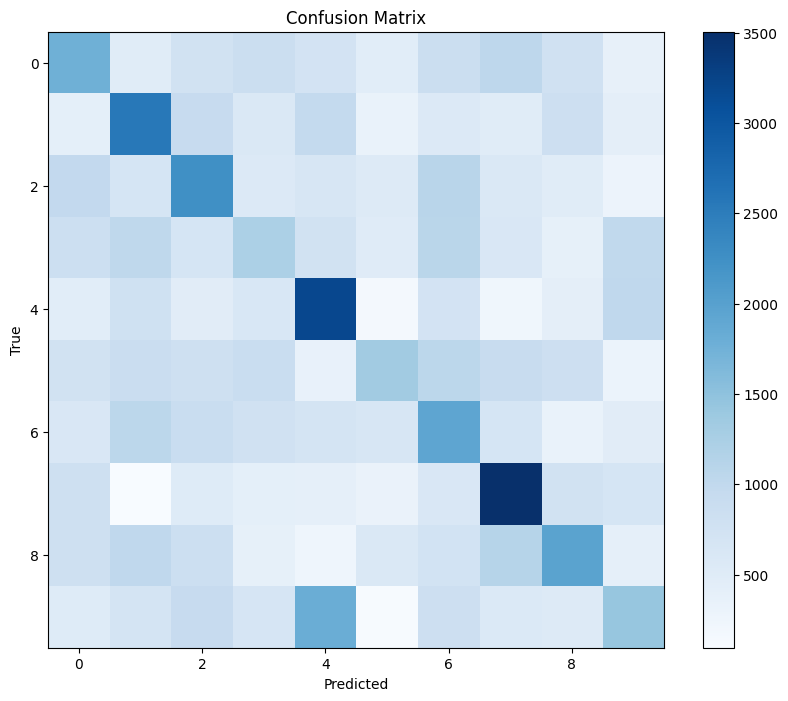


Model saved as final_auth_model.pkl


In [ ]:

# Main Pipeline
if __name__ == "__main__":
    # 1. Load data
    print("Loading data...")
    X, y = load_and_process_data("/content/drive/MyDrive/Dataset")
    print(f"Dataset shape: {X.shape} | Classes: {len(np.unique(y))}")

    # 2. Feature selection
    print("\nSelecting top features...")
    selector = SelectKBest(mutual_info_classif, k=20)
    X_reduced = selector.fit_transform(X, y)
    feature_scores = selector.scores_

    # Plot feature importance
    plt.figure(figsize=(12,6))
    plt.barh(range(len(feature_scores)), feature_scores, align='center')
    plt.yticks(range(len(feature_scores)), [f"Feature {i}" for i in range(len(feature_scores))])
    plt.xlabel("Mutual Information Score")
    plt.title("Feature Importance")
    plt.show()

    # 3. Model comparison
    models = {
        "LDA": make_pipeline(StandardScaler(), LinearDiscriminantAnalysis()),
        "kNN": make_pipeline(StandardScaler(),
                            KNeighborsClassifier(n_neighbors=5, weights='distance')),
        "Logistic Regression": make_pipeline(StandardScaler(),
                                            LogisticRegression(C=0.1, max_iter=1000))
    }

    print("\nEvaluating models:")
    results = {}
    for name, model in models.items():
        cv = StratifiedKFold(n_splits=5, shuffle=True)
        scores = cross_val_score(model, X_reduced, y, cv=cv, n_jobs=-1)
        results[name] = scores
        print(f"{name}: {np.mean(scores):.2f} ± {np.std(scores):.2f}")

    # 4. Train best model
    print("\nTraining final model...")
    final_model = make_pipeline(
        StandardScaler(),
        SelectKBest(mutual_info_classif, k=20),
        LinearDiscriminantAnalysis()
    )
    final_model.fit(X, y)

    # 5. Evaluation
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
    y_pred = final_model.predict(X_test)

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10,8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # 6. Save model
    joblib.dump(final_model, "final_auth_model.pkl")
    print("\nModel saved as final_auth_model.pkl")

# Usage Example
def authenticate_user(sensor_data):
    """sensor_data: DataFrame with WINDOW_SIZE rows of sensor readings"""
    features = extract_features(sensor_data)
    return final_model.predict([features])[0]
